# 🔥 GMRES WILDFIRE OPTIMIZATION 🔥

El objetivo es encontrar la presión el paso de tiempo siguiente de la simulación, tenemos un campo de presión en 2D, pero se puede aplanar como un vector.

Para encontrar el vector de presión $p$ se resuelve la siguiente iteración de punto fijo, utilizando Fourier:

$$
\nabla_h^2 \; p^{m+1} = \frac{\rho^n}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u^{n+1}) + \frac{1}{\rho^n} \nabla_h \rho^N \cdot \nabla_h p^m
$$

Considerando:
1. condiciones de borde periódicas en $X$ y Dirichlet ($p=0$) en $Z=0$ y $Z=2 \pi$.
2. $X, Y \in [0, 2\pi]$.

---

# Cocinar un caso base

podemos revertir la iteración de punto fijo:
$$
\begin{align*}
\nabla_h^2 \; p^{m+1} &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) + \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h p^m \\

\nabla_h^2 \; p^{m} &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) + \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h p^m \\

(\nabla_h^2 - \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h ) \; p &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) \\

A p &= b
\end{align*}
$$

Ahora podemos definir $A$ y $p$, realizar la multiplicación y obtener un sistma para el cual conocemos la respuesta. Lo cual luego sera útil para compara distintos métodos. Para cumplir este objetivo necesitamos el campo de presión $P$ y el campo de densidad $\rho$, pero para construir un caso con al menos un poco de sentido físico, creo que tiene más sentido seguir flujo: 
1. partimos de crear la temperatura con un par de plumas.
2. el calor del incendio es el que modifica la densidad 
3. la difrencia de densidad crea un gradiente de presión.

$T$ -> $\rho$ -> $p$

$$
\begin{align*}
(\nabla_h^2 \; p - \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h \; p )  = b \\
afun(p) = b
\end{align*}
$$

## 1. Definir Campos de $T,\rho,p$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import gmres, LinearOperator
import time
import os

In [3]:
debug_flag = True
def debug(msg):
    if debug_flag:
        print(msg)

In [4]:
def initialize_variables(Nx=64, Nz=64, X_max=2*np.pi, Z_max=2*np.pi):
    """
    Configura los parámetros del problema, la malla y las coordenadas.
    
    Return:
        Un diccionario (params) con todas las variables de la malla.
    """
    debug("==== Inicializando Dominio ====")    
    dx = X_max / Nx
    dz = Z_max / Nz

    debug(f"Dominio: [0, {X_max:.2f}] x [0, {Z_max:.2f}]")
    debug(f"Malla total: {Nx} x {Nz} = {Nx * Nz} puntos")
    debug(f"Malla interior (sin fronteras): {Nx} x {Nz - 2} = {Nx * (Nz - 2)} incógnitas")
    debug(f"Pasos: dx = {dx:.4f}, dz = {dz:.4f}")
    
    x_coords = np.linspace(0, X_max, num=Nx)
    z_coords = np.linspace(0, Z_max, num=Nz)
    
    X, Z = np.meshgrid(x_coords, z_coords, indexing='xy')
    

    params = {}
    # PARÁMTEROS DOMINIO
    params['Nx']            = Nx
    params['Nz']            = Nz
    params['Xmax']          = X_max
    params['Zmax']          = Z_max
    params['dx']            = dx
    params['dz']            = dz
    params['X']             = X
    params['Z']             = Z
    # PARÁMETROS: FÍSICOS
    params['gravity']       = 9.81      # [m/s^2]
    # params['force_p_zero']  = True      # condición eje Z
    params['p_atm']         = 101325.0  # 1atm nivl mar
    params['R_gas']         = 287.05    # R_aire = R_universal / M_aire = 8314.46 / 28.97 ≈ 287 J/(kg·K)
    params['T_ambiente']    = 300.0     # [K]
    # PARÁMETROS: OTROS
    params['seed']          = 42
    
    debug("=" * 40)
    return params

In [5]:
def get_temperature_field(params):
    """
    Genera un campo de temperatura
    Condiciones de borde:
    - Periódica en X (la temperatura en x=0 y x=Xmax es la misma)
    - En Z: transición suave desde zona caliente (z≈0) a ambiente (z=Zmax)
    
    Return:
        T: array 2D (Nz x Nx) con el campo de temperatura en Kelvin
    """
    debug("==== Generado Campo de Temperatura ====")    
    X = params['X']
    Z = params['Z']
    Nx = params['Nx']
    Nz = params['Nz']
    Xmax = params['Xmax']
    Zmax = params['Zmax']
    np.random.seed(params['seed'])
    
    # --- PARÁMETROS FÍSICOS ---
    T_ambient = params['T_ambiente']
    T_flame = 1200.0       # Temperatura de llama [K] ≈ 927°C
    T_plume_max = 800.0    # Temperatura máxima en la pluma [K] ≈ 527°C
    
    # --- TRABAJAR CON MITAD DEL DOMINIO EN X (para simetría) ---
    Nx_half = Nx // 2
    X_half = X[:, :Nx_half]
    Z_half = Z[:, :Nx_half]
    T_half = np.zeros((Nz, Nx_half))
    
    # Normalización vertical [0, 1]
    z_norm = Z_half / Zmax
    
    # --- 1. FUENTE DE CALOR EN EL SUELO (ZONA DE COMBUSTIÓN) ---
    # Forma
    x_fire_center = Xmax / 4.0  
    x_fire_width = Xmax / 10.0 
    x_dist = np.abs(X_half - x_fire_center)
    fire_horizontal = np.exp(-(x_dist / x_fire_width)**2)
    z_fire_height = 0.4  # El fuego se concentra en el 15% inferior
    fire_vertical = np.exp(-z_norm / z_fire_height)
    
    # Temperatura
    T_fire_source = T_ambient + (T_flame - T_ambient) * fire_horizontal * fire_vertical
    
    # --- 2. PLUMA TÉRMICA ASCENDENTE ---
    # Forma
    plume_width_base = x_fire_width * 1.2
    plume_width = plume_width_base * (1.0 + 3.0 * z_norm)
    plume_horizontal = np.exp(-(x_dist / plume_width)**2)
    z_plume_peak = 0.35
    z_plume_width = 0.25
    plume_vertical = np.exp(-((z_norm - z_plume_peak) / z_plume_width)**2)
    plume_decay = np.exp(-z_norm / 0.6)
    
    # Temperatura
    T_plume = T_ambient + (T_plume_max - T_ambient) * \
              plume_horizontal * plume_vertical * plume_decay
    
    # --- 3. ENTRAINMENT (aire frío arrastrado desde los flancos) ---
    # Reduce la temperatura en las zonas laterales cerca de la pluma
    entrainment_factor = (1.0 - plume_horizontal) * \
                         np.exp(-((z_norm - 0.3) / 0.4)**2) * \
                         z_norm  # Solo en altura, no en suelo
    
    T_entrainment_effect = -20.0 * entrainment_factor  
    
    # --- 4. GRADIENTE VERTICAL SUAVE HACIA TEMPERATURA AMBIENTE ---
    # Asegura que en z=Zmax estemos cerca de T_ambient
    T_background = T_ambient + (T_plume_max - T_ambient) * 0.1 * (1.0 - z_norm)
    
    # --- 5. TURBULENCIA TÉRMICA MULTIESCALA ---
    # Más intensa cerca de la pluma, menor lejos de ella
    T_turbulence = np.zeros_like(T_half)
    for kx in [2, 4, 6, 8, 10]:
        for kz in [1, 2, 3, 4, 5]:
            # Fases aleatorias
            phase_x = np.random.rand() * 2 * np.pi
            phase_z = np.random.rand() * 2 * np.pi
            amplitude = np.random.uniform(2.0, 10.0) / (kx + kz)
            mode = amplitude * \
                   np.sin(kx * 2*np.pi * X_half/Xmax + phase_x) * \
                   np.sin(kz * np.pi * z_norm + phase_z)
            if kx >= 6:  # Escalas pequeñas: solo cerca de la pluma
                spatial_modulation = plume_horizontal * (1.0 - 0.7 * z_norm)
            else:  # Escalas grandes: en todo el dominio pero decaen con altura
                spatial_modulation = 0.3 + 0.7 * plume_horizontal * np.exp(-z_norm/0.5)
            
            mode *= spatial_modulation
            T_turbulence += mode
    
    # --- 6. COMPOSICIÓN DEL CAMPO TOTAL ---
    # Usar máximo entre fuente y pluma
    T_core = np.maximum(T_fire_source, T_plume)
    T_half = T_core + T_entrainment_effect + T_turbulence
    T_half = np.maximum(T_half, T_ambient)
    edge_blend = 0.05
    n_blend = int(Nz * edge_blend)
    
    for i in range(n_blend):
        blend_factor = i / n_blend
        idx = Nz - 1 - i
        T_half[idx, :] = blend_factor * T_half[idx, :] + (1 - blend_factor) * T_ambient
    
    T = np.zeros((Nz, Nx))
    T[:, :Nx_half] = T_half
    T[:, Nx_half:] = np.fliplr(T_half)
    
    debug(f"  - Rango: [{T.min():.2f}, {T.max():.2f}] K")
    debug(f"  - Rango en °C: [{T.min()-273.15:.2f}, {T.max()-273.15:.2f}]")
    debug(f"  - Media: {T.mean():.2f} K ({T.mean()-273.15:.2f} °C)")
    debug(f"  - Desv. estándar: {T.std():.2f} K")
    
    diff_periodic = np.abs(T[:, 0] - T[:, -1])
    debug(f"  - Verificación periodicidad (max |T[:,0] - T[:,-1]|): {diff_periodic.max():.6e} K")
    
    T_bottom = T[0, :].mean()
    T_top = T[-1, :].mean()
    debug(f"  - T promedio en z=0: {T_bottom:.2f} K ({T_bottom-273.15:.2f} °C)")
    debug(f"  - T promedio en z=Zmax: {T_top:.2f} K ({T_top-273.15:.2f} °C)")
    
    if T.min() < 200.0 or T.max() > 2000.0:
        debug(f" ADVERTENCIA: Temperaturas fuera del rango físico esperado!")
    
    debug("=" * 40)

    return T

In [6]:
def get_density_from_temperature(T, params):
    """
    Calcula el campo de densidad a partir del campo de temperatura
    usando la ecuación de estado para un gas ideal.
    
    densidad = p_0 / (R T)
    """
    debug("==== Generado Campo de Densidad ====")
    
    p_atm = params['p_atm']
    R_gas = params['R_gas']
    T_ambiente = params['T_ambiente']
    
    # --- CÁLCULO DE DENSIDAD ---
    rho_reference = p_atm / (R_gas * T_ambiente)    
    rho = p_atm / (R_gas * T)
    
    # --- VERIFICACIONES DE SEGURIDAD ---
    if np.any(T <= 0):
        debug(f"  ERROR: Temperaturas no positivas detectadas!")
        debug(f"  Mínimo: {T.min():.2f} K")
        raise ValueError("Temperatura debe ser positiva para calcular densidad")
    
    if np.any(np.isnan(rho)) or np.any(np.isinf(rho)):
        debug(f"  ERROR: Valores NaN o Inf en densidad!")
        raise ValueError("Densidad contiene valores no válidos")
    
    debug(f"  - Rango: [{rho.min():.4f}, {rho.max():.4f}] kg/m³")
    debug(f"  - Media: {rho.mean():.4f} kg/m³")
    debug(f"  - Desv. estándar: {rho.std():.4f} kg/m³")
    
    density_ratio = rho.max() / rho.min()
    debug(f"  - Razón densidad_max/densidad_min: {density_ratio:.2f}")
    
    diff_periodic = np.abs(rho[:, 0] - rho[:, -1])
    debug(f"  - Verificación periodicidad (max |densidad[:,0] - densidad[:,-1]|): {diff_periodic.max():.6e} kg/m³")
    
    params['rho_reference'] = rho_reference
    params['density_ratio'] = density_ratio
    
    debug("=" * 40)
    
    return rho

In [7]:
def get_pressure_from_density(rho, params):
    """
    Calcula presión por integración hidrostática vertical.
    
    dp/dz = -densidad(x,z) g
    """
    Nz = params['Nz']
    Nx = params['Nx']
    dz = params['dz']
    g = params['gravity']
    p_atm = params['p_atm']

    p = np.zeros_like(rho)
    p[-1, :] = p_atm    
    # --- INTEGRACIÓN VERTICAL DESDE ARRIBA HACIA ABAJO trapecio 
    for i in range(Nz - 2, -1, -1):
        rho_avg = 0.5 * (rho[i, :] + rho[i+1, :])
        p[i, :] = p[i+1, :] + rho_avg * g * dz
    
    
    debug("==== Generado Campo de Presión ====")        
    # --- DIAGNÓSTICOS ---
    debug(f"  - Rango: [{p.min():.2f}, {p.max():.2f}] Pa")
    debug(f"  - Media: {p.mean():.2f} Pa")
    debug(f"  - Desv. estándar: {p.std():.2f} Pa")
    
    diff_periodic = np.abs(p[:, 0] - p[:, -1])
    debug(f"  - Verificación periodicidad (max |p[:,0] - p[:,-1]|): {diff_periodic.max():.6e} Pa")

    p_bottom = p[0, :].mean()
    p_top = p[-1, :].mean()
    
    debug(f"  - p promedio en z=0: {p_bottom:.2f} [Pa]")
    debug(f"  - p promedio en z=Zmax: {p_top:.2f} [Pa]")
    
    debug("=" * 40)

    return p


==== Inicializando Dominio ====
Dominio: [0, 6.28] x [0, 6.28]
Malla total: 32 x 32 = 1024 puntos
Malla interior (sin fronteras): 32 x 30 = 960 incógnitas
Pasos: dx = 0.1963, dz = 0.1963
==== Generado Campo de Temperatura ====
  - Rango: [300.00, 1197.54] K
  - Rango en °C: [26.85, 924.39]
  - Media: 441.11 K (167.96 °C)
  - Desv. estándar: 159.92 K
  - Verificación periodicidad (max |T[:,0] - T[:,-1]|): 0.000000e+00 K
  - T promedio en z=0: 609.37 K (336.22 °C)
  - T promedio en z=Zmax: 300.00 K (26.85 °C)
==== Generado Campo de Densidad ====
  - Rango: [0.2948, 1.1766] kg/m³
  - Media: 0.8758 kg/m³
  - Desv. estándar: 0.2244 kg/m³
  - Razón densidad_max/densidad_min: 3.99
  - Verificación periodicidad (max |densidad[:,0] - densidad[:,-1]|): 0.000000e+00 kg/m³
==== Generado Campo de Presión ====
  - Rango: [101325.00, 101388.37] Pa
  - Media: 101353.27 Pa
  - Desv. estándar: 15.84 Pa
  - Verificación periodicidad (max |p[:,0] - p[:,-1]|): 0.000000e+00 Pa
  - p promedio en z=0: 101377.

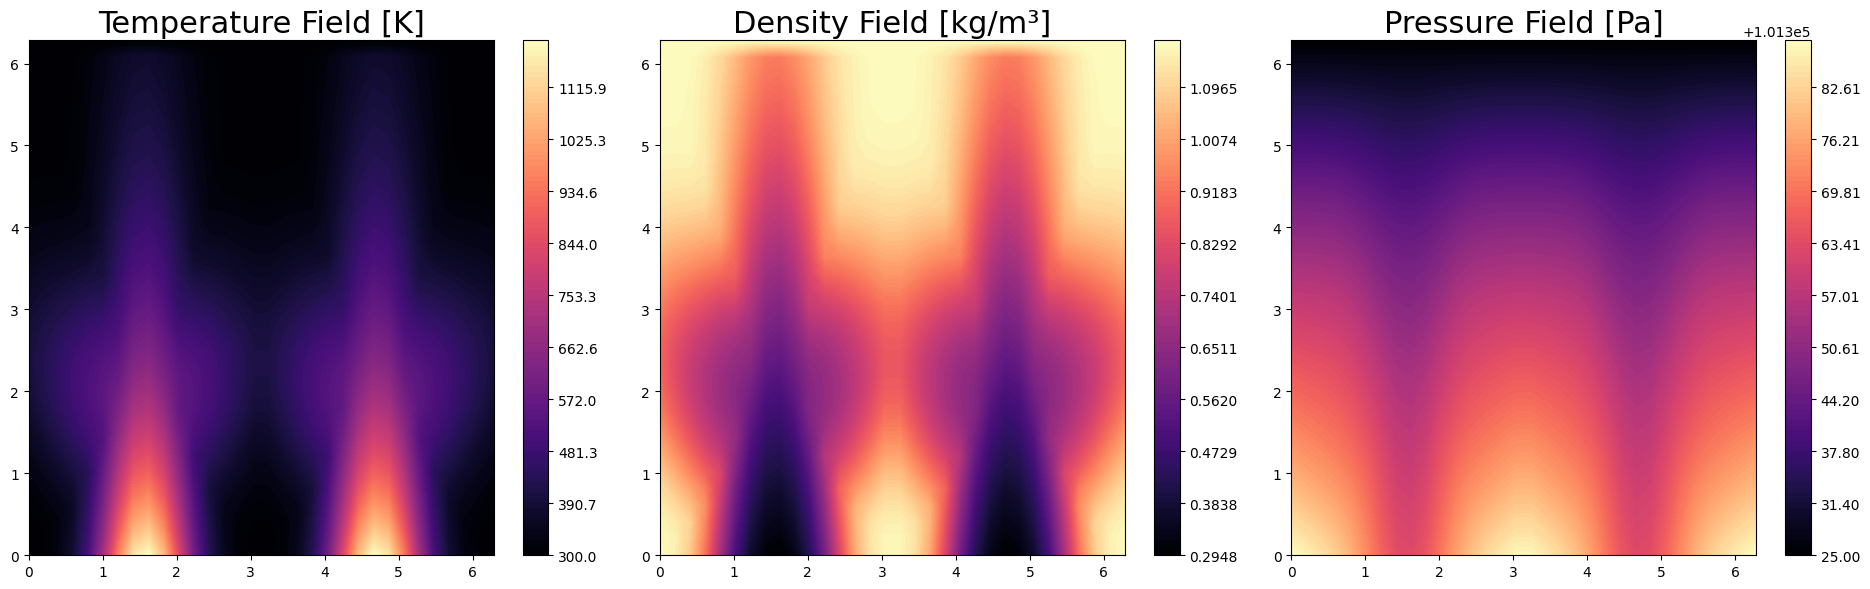

In [10]:
def plot_field(campo, params, titulo="titulo por defecto", label="variable"):
    """
    Grafica un campo de presión, temperatura o lo que sea 2D los parámetros de la malla.
    """
    X = params['X']
    Z = params['Z']
    Zmax = params['Zmax']
    
    plt.figure(figsize=(10, 7))
    min_val, max_val = campo.min(), campo.max()
    levels = np.linspace(min_val, max_val, 100)
    contour = plt.contourf(X, Z, campo, levels=levels, cmap='magma')

    plt.colorbar(contour, label=label)
    plt.xlabel('Eje X (periódico)')
    plt.ylabel('Eje Z')
    plt.title(titulo)    
    plt.tight_layout()
    plt.show()

def plot_all_fields_contourf(T, rho, p, params, 
                             subplot_title_size=22):
    """
    Plots Temperature, Density, and Pressure fields in a 1x3 subplot
    """
    try:
        X = params['X']
        Z = params['Z']
    except KeyError:
        print("Error: 'params' must contain 'X' and 'Z' coordinate meshes.")
        return
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 6))
    
    # --- Temperatura ---
    min_T, max_T = T.min(), T.max()
    levels_T = np.linspace(min_T, max_T, 100)
    cf1 = ax1.contourf(X, Z, T, levels=levels_T, cmap='magma')
    ax1.set_title("Temperature Field [K]", fontsize=subplot_title_size) 
    fig.colorbar(cf1, ax=ax1)
    
    # --- Densidad ---
    min_rho, max_rho = rho.min(), rho.max()
    levels_rho = np.linspace(min_rho, max_rho, 100)
    cf2 = ax2.contourf(X, Z, rho, levels=levels_rho, cmap='magma')
    ax2.set_title("Density Field [kg/m³]", fontsize=subplot_title_size)
    fig.colorbar(cf2, ax=ax2)
    
    # --- Presión ---
    min_p, max_p = p.min(), p.max()
    levels_p = np.linspace(min_p, max_p, 100)    
    cf3 = ax3.contourf(X, Z, p, levels=levels_p, cmap='magma')
    ax3.set_title("Pressure Field [Pa]", fontsize=subplot_title_size)
    fig.colorbar(cf3, ax=ax3)
    
    plt.tight_layout() 
    plt.show()


params = initialize_variables(Nx=32, Nz=32)
T = get_temperature_field(params)
rho = get_density_from_temperature(T, params)
p = get_pressure_from_density(rho, params)
plot_all_fields_contourf(T, rho, p,params)

## 2. afun(p)

La formación de la matriz $A$ no es necesaria, por lo que podemos trabajar de forma *Matrix-Free* con una función `afun(p)`

Ya tenemos los campo de $p$ y $\rho$, así que ahora para construir la matri A, solo necesitamos definir los operadores de gradiente y laplaciano, lo cual se puede hacer con una matriz de diferencias
$$
\begin{align*}

(\nabla_h^2 - \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h ) \; p &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) \\
(\nabla_h^2 \; p - \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h \; p )  &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) \\
afun(p) &= b
\end{align*}
$$

### $\nabla^2$ Laplaciano

El operador laplaciano con diferencias finitas queda así:
$$
\nabla^2 = \frac{\nabla^2 p}{\nabla x^2} + \frac{\nabla^2 p}{\nabla z^2} = \frac{p_{i+1,k} - 2p_{i,k} + p_{i-1,k}}{\Delta x^2} + \frac{p_{i,k+1} - 2p_{i,k} - 2p_{i,k} + p_{i,k-1}}{\Delta z^2}
$$

Ahora podemos usar una matrices de difrencias $D_x$ y $D_z$ para expressar cada una de las partes del laplaciano:

$$
L_x = \frac{1}{\Delta x^2} 
\begin{pmatrix} 
-2 & 1 & 0 & 0 & \mathbf{1} \\
 1 & -2 & 1 & 0 & 0         \\ 
 0 & 1 & -2 & 1 & 0         \\ 
 0 & 0 & 1 & -2 & 1         \\ 
 \mathbf{1} & 0 & 0 & 1 & -2 
 \end{pmatrix} 
$$

$$
L_z = \frac{1}{\Delta z^2} 
\begin{pmatrix} 
-2 & 1 & 0 & 0 & 0 \\
 1 & -2 & 1 & 0 & 0 \\
 0 & 1 & -2 & 1 & 0 \\
 0 & 0 & 1 & -2 & 1 \\
 0 & 0 & 0 & 1 & -2 
\end{pmatrix} 
$$

Ahora si consideramos que nosotros queremos resolver $A p = b$ donde $p$ no es una matriz de presión, si no la matriz aplanda en un vector, no tiene sentido hacer $(D_x + Dz)p$, estuve discutiendo con GPT y me dijo que el problema de dimensiones se soluciona con el producto kroncker y logré ver porque las dimensiones dejan de ser un problema, pero veo el por qué tiene sentido :c

$$
\nabla^2_h = \frac{1}{\Delta x^2}(L_x \otimes I_z) + \frac{1}{\Delta z^2} (I_x \otimes L_z)
$$


## **2. afun(p) - Enfoque Matrix-Free**

La formación explícita de la matriz $A$ no es necesaria. Podemos trabajar de forma *Matrix-Free* con una función `afun(p)` que aplica el operador lineal.

Ya tenemos los campos de $p$ y $\rho$, así que ahora para construir el operador $A$, solo necesitamos definir los operadores de gradiente y laplaciano usando matrices de diferencias.

### 2.1 Formulación del sistema lineal

Partimos de la iteración de punto fijo:
$$
\begin{align*}
\nabla_h^2 p^{m+1} - \frac{1}{\rho^n} \nabla_h \rho^n \cdot \nabla_h p^{m+1} &= \frac{\rho^n}{\Delta t} (\nabla_h \cdot \mathbf{u}^* - \nabla_h \cdot \mathbf{u}^{n+1}) \\
\underbrace{\left(\nabla_h^2 - \frac{1}{\rho^n} \nabla_h \rho^n \cdot \nabla_h \right)}_{A} p^{m+1} &= \underbrace{\frac{\rho^n}{\Delta t} (\nabla_h \cdot \mathbf{u}^* - \nabla_h \cdot \mathbf{u}^{n+1})}_{b}
\end{align*}
$$

Por lo tanto:
$$
\boxed{A(p) = b} \quad \text{donde} \quad A(p) = \nabla_h^2 p - \frac{1}{\rho^n} (\nabla_h \rho^n \cdot \nabla_h p)
$$

---


### 2.2 Operador Laplaciano $\nabla_h^2$

El operador laplaciano con diferencias finitas centradas de segundo orden es:
$$
\nabla_h^2 p = \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2} = \frac{p_{i+1,k} - 2p_{i,k} + p_{i-1,k}}{\Delta x^2} + \frac{p_{i,k+1} - 2p_{i,k} + p_{i,k-1}}{\Delta z^2}
$$

#### Matrices de diferencias 1D

Para aproximar las segundas derivadas en cada dirección, usamos matrices tridiagonales:

**En dirección $x$ (con periodicidad):**
$$
D_x = \frac{1}{\Delta x^2} 
\begin{pmatrix} 
-2 & 1 & 0 & \cdots & 0 & \mathbf{1} \\
 1 & -2 & 1 & \cdots & 0 & 0         \\ 
 0 & 1 & -2 & \ddots & \vdots & \vdots         \\ 
 \vdots & \ddots & \ddots & \ddots & 1 & 0         \\ 
 0 & \cdots & 0 & 1 & -2 & 1         \\ 
 \mathbf{1} & 0 & \cdots & 0 & 1 & -2 
 \end{pmatrix}_{N_x \times N_x}
$$

Los términos en **negrita** (esquinas superior derecha e inferior izquierda) implementan la periodicidad en $x$.

**En dirección $z$ (sin Neumann/Dirichlet):**
$$
D_z = \frac{1}{\Delta z^2} 
\begin{pmatrix} 
-2 & 1 & 0 & 0 & \cdots & 0 \\
 1 & -2 & 1 & 0 & \cdots & 0 \\
 0 & 1 & -2 & 1 & \ddots & \vdots \\
 \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
 0 & \cdots & 0 & 1 & -2 & 1 \\
 0 & \cdots & \cdots & 0 & 1 & -2
 \end{pmatrix}_{N_z \times N_z}
$$

#### ¿Por qué el producto de Kronecker?

El problema es que $p$ está aplanado en un vector de tamaño $N_x \cdot N_z$, ordenado como:
$$
p_{vec} = [p_{0,0}, p_{0,1}, \ldots, p_{0,N_z-1}, p_{1,0}, p_{1,1}, \ldots, p_{N_x-1,N_z-1}]^T
$$

Si intentamos aplicar $D_x$ directamente, las dimensiones no coinciden. **El producto de Kronecker resuelve esto:**

$$
\boxed{\nabla_h^2 = D_x \otimes I_{N_z} + I_{N_x} \otimes D_z}
$$

donde $I_{N_x}$ e $I_{N_z}$ son matrices identidad.

---


### 2.3 Operador de gradiente $\nabla_h$

El gradiente discreto usando diferencias centrales es:
$$
\nabla_h p = \left(\frac{\partial p}{\partial x}, \frac{\partial p}{\partial z} \right) = \left( \frac{p_{i+1,k} - p_{i-1,k}}{2\Delta x}, \frac{p_{i,k+1} - p_{i,k-1}}{2\Delta z}\right)
$$

#### Matrices de gradiente 1D

**En dirección $x$ (con periodicidad):**
$$
G_x = \frac{1}{2\Delta x} 
\begin{pmatrix} 
 0 & 1 & 0 & \cdots & 0 & \mathbf{-1} \\
 \mathbf{-1} & 0 & 1 & 0 & \cdots & 0 \\
 0 & -1 & 0 & 1 & \ddots & \vdots \\
 \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
 0 & \cdots & 0 & -1 & 0 & 1 \\
 \mathbf{1} & 0 & \cdots & 0 & -1 & 0
\end{pmatrix}_{N_x \times N_x}
$$

**En dirección $z$:**
$$
G_z = \frac{1}{2\Delta z} 
\begin{pmatrix} 
 0 & 1 & 0 & \cdots & 0 \\
 -1 & 0 & 1 & \ddots & \vdots \\
 0 & -1 & 0 & \ddots & 0 \\
 \vdots & \ddots & \ddots & \ddots & 1 \\
 0 & \cdots & 0 & -1 & 0
\end{pmatrix}_{N_z \times N_z}
$$

#### Expansión a 2D con Kronecker

Para aplicar estos operadores al vector aplanado:

$$
\boxed{
\begin{align*}
\nabla_{h,x} &= G_x \otimes I_{N_z} \\
\nabla_{h,z} &= I_{N_x} \otimes G_z
\end{align*}
}
$$

Entonces el gradiente de cualquier campo escalar $\phi_{vec}$ es:
$$
\nabla_h \phi = \begin{pmatrix} \nabla_{h,x} \phi_{vec} \\ \nabla_{h,z} \phi_{vec} \end{pmatrix}
$$

**Importante:** Cada componente es un vector de tamaño $N_x \cdot N_z$.

---


### 2.4 Término de densidad variable: $\frac{1}{\rho^n} (\nabla_h \rho^n \cdot \nabla_h p)$

Este término acopla la densidad con el gradiente de presión y es la fuente de la no-linealidad en la ecuación de Poisson original.

#### Paso 1: Calcular $\nabla_h \rho^n$ (pre-cálculo)

Ya que $\rho^n$ es conocido en la iteración $m$, calculamos su gradiente **una sola vez**:

$$
\begin{align*}
(\nabla_h \rho^n)_x &= \nabla_{h,x} \cdot \rho_{vec}^n = (G_x \otimes I_{N_z}) \rho_{vec}^n \\
(\nabla_h \rho^n)_z &= \nabla_{h,z} \cdot \rho_{vec}^n = (I_{N_x} \otimes G_z) \rho_{vec}^n
\end{align*}
$$

Estos son vectores de tamaño $N_x \cdot N_z$.

#### Paso 2: Calcular $\nabla_h p^{m+1}$ (dentro de afun)

Para cada evaluación de `afun(p)` necesitamos:

$$
\begin{align*}
(\nabla_h p)_x &= \nabla_{h,x} \cdot p_{vec} = (G_x \otimes I_{N_z}) p_{vec} \\
(\nabla_h p)_z &= \nabla_{h,z} \cdot p_{vec} = (I_{N_x} \otimes G_z) p_{vec}
\end{align*}
$$

#### Paso 3: Producto punto $\nabla_h \rho^n \cdot \nabla_h p$

Este es un producto punto **element-wise** (en cada punto de la malla):

$$
\nabla_h \rho^n \cdot \nabla_h p = (\nabla_h \rho^n)_x \odot (\nabla_h p)_x + (\nabla_h \rho^n)_z \odot (\nabla_h p)_z
$$

donde $\odot$ denota multiplicación elemento a elemento (Hadamard). El resultado es un vector de tamaño $N_x \cdot N_z$.

#### Paso 4: División por densidad $\frac{1}{\rho^n}$

Finalmente, dividimos por la densidad **elemento a elemento**:

$$
\frac{1}{\rho^n} (\nabla_h \rho^n \cdot \nabla_h p) = \frac{1}{\rho_{vec}^n} \odot \left[(\nabla_h \rho^n)_x \odot (\nabla_h p)_x + (\nabla_h \rho^n)_z \odot (\nabla_h p)_z\right]
$$

**Cuidado:** Proteger contra división por cero: $\frac{1}{\max(\rho^n, \epsilon)}$ con $\epsilon \sim 10^{-10}$.

---



### 2.5 Ensamblaje final de afun(p)

Juntando todo:

$$
\boxed{
\text{afun}(p) = \underbrace{(D_x \otimes I_{N_z} + I_{N_x} \otimes D_z) p_{vec}}_{\text{Laplaciano}} - \underbrace{\frac{1}{\rho_{vec}^n} \odot \left[(\nabla_h \rho^n) \cdot (\nabla_h p)\right]}_{\text{Corrección por densidad variable}}
}
$$

In [11]:
def build_Dx_periodic(Nx, dx):
    """
    Construye la matriz de segunda derivada en x con condiciones periódicas.    
    Aproxima: d²/dx² con diferencias finitas centradas de 2° orden
    Parámetros:
    -----------
    Nx : int
        Número de puntos en x
    dx : float
        Espaciado de la malla
    Retorna:
    --------
    Dx : sparse matrix (Nx x Nx)
        Operador de segunda derivada
    """
    # Matriz tridiagonal
    Dx = diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx), format='lil')
    # Condiciones periódicas: conectar extremos
    Dx[0, -1] = 1
    Dx[-1, 0] = 1   
    Dx = Dx / (dx**2)
    
    return csr_matrix(Dx)

def build_Dz(Nz, dz):
    """
    Construye la matriz de segunda derivada en z con:
    - Neumann en z=0 (bottom): dp/dz = 0
    - Dirichlet en z=Nz (top): p = p_top (se maneja en RHS)
    
    Parámetros:
    -----------
    Nz : int
        Número de puntos en z
    dz : float
        Espaciado de la malla
    
    Retorna:
    --------
    Dz : sparse matrix (Nz x Nz)
        Operador de segunda derivada
    """
    # Matriz tridiagonal estándar
    Dz = diags([1, -2, 1], [-1, 0, 1], shape=(Nz, Nz), format='csr')
    Dz = Dz / (dz**2)
    
    return csr_matrix(Dz)


def build_Gx_periodic(Nx, dx):
    """
    Construye la matriz de primera derivada en x con condiciones periódicas.
    
    Aproxima: d/dx con diferencias centradas de 2° orden
    
    Parámetros:
    -----------
    Nx : int
        Número de puntos en x
    dx : float
        Espaciado de la malla
    
    Retorna:
    --------
    Gx : sparse matrix (Nx x Nx)
        Operador de gradiente
    """
    Gx = diags([-1, 1], [-1, 1], shape=(Nx, Nx), format='lil')
    
    # Condiciones periódicas
    Gx[0, -1] = -1   # Primera fila
    Gx[-1, 0] = 1    # Última fila
    
    Gx = Gx / (2 * dx)
    
    return csr_matrix(Gx)


def build_Gz(Nz, dz):
    """
    Construye la matriz de primera derivada en z.
    
    Aproxima: d/dz con diferencias centradas de 2° orden
    
    Parámetros:
    -----------
    Nz : int
        Número de puntos en z
    dz : float
        Espaciado de la malla
    
    Retorna:
    --------
    Gz : sparse matrix (Nz × Nz)
        Operador de gradiente
    """
    Gz = diags([-1, 1], [-1, 1], shape=(Nz, Nz), format='lil')
        
    Gz = Gz / (2 * dz)
    
    return csr_matrix(Gz)


# ==============================================================================
# PASO 2: Expansión a 2D usando producto de Kronecker
# ==============================================================================

def build_2d_operators(Nx, Nz, dx, dz):
    """
    Construye todos los operadores 2D necesarios para el problema de presión.
    
    Parámetros:
    -----------
    Nx, Nz : int
        Número de puntos en x y z
    dx, dz : float
        Espaciado de la malla
    
    Retorna:
    --------
    L : sparse matrix (Nx·Nz × Nx·Nz)
        Operador Laplaciano 2D
    Gx_2d, Gz_2d : sparse matrices
        Operadores de gradiente 2D
    """
    print("Construyendo operadores 1D...")
    
    Dx = build_Dx_periodic(Nx, dx)
    Dz = build_Dz(Nz, dz)
    Gx = build_Gx_periodic(Nx, dx)
    Gz = build_Gz(Nz, dz)
    
    Ix = eye(Nx, format='csr')
    Iz = eye(Nz, format='csr')
    
    print("Aplicando producto de Kronecker para 2D...")
    
    L = kron(Dx, Iz) + kron(Ix, Dz)
    
    Gx_2d = kron(Gx, Iz)
    Gz_2d = kron(Ix, Gz)
    
    print(f"  Laplaciano: {L.shape}, nnz={L.nnz}")
    print(f"  Gradiente x: {Gx_2d.shape}, nnz={Gx_2d.nnz}")
    print(f"  Gradiente z: {Gz_2d.shape}, nnz={Gz_2d.nnz}")
    
    return L, Gx_2d, Gz_2d


# ==============================================================================
# PASO 3: Construcción de afun
# ==============================================================================

def create_afun(L, Gx_2d, Gz_2d, rho_vec):
    """
    Crea la función afun para GMRES que implementa:
    
    A(p) = ∇²p - (1/rho) · (∇rho · ∇p)
    
    Parámetros:
    -----------
    L : sparse matrix
        Operador Laplaciano 2D
    Gx_2d, Gz_2d : sparse matrices
        Operadores de gradiente 2D
    rho_vec : ndarray (Nx·Nz,)
        Vector de densidad aplanado
    
    Retorna:
    --------
    afun : función
        Función que aplica el operador A(p)
    grad_rho_x, grad_rho_z : ndarray
        Gradientes de densidad (para inspección)
    """
    print("\nPre-calculando gradiente de densidad...")
    
    grad_rho_x = Gx_2d @ rho_vec
    grad_rho_z = Gz_2d @ rho_vec
    
    print(f"  |∇rho_x| = {np.linalg.norm(grad_rho_x):.6e}")
    print(f"  |∇rho_z| = {np.linalg.norm(grad_rho_z):.6e}")
    
    epsilon = 1e-10
    inv_rho = 1.0 / np.maximum(rho_vec, epsilon)
    
    print(f"  1/ρ ∈ [{inv_rho.min():.6e}, {inv_rho.max():.6e}]")
    
    def afun(p_vec):
        lap_p = L @ p_vec
        
        grad_p_x = Gx_2d @ p_vec
        grad_p_z = Gz_2d @ p_vec
        
        dot_product = grad_rho_x * grad_p_x + grad_rho_z * grad_p_z
        correction = inv_rho * dot_product
        
        result = lap_p - correction
        
        return result
    
    return afun, grad_rho_x, grad_rho_z

---

# Propuesta 1: Resolución directa con GMRES

podemos revertir la iteración de punto fijo:
$$
\begin{align*}
\nabla_h^2 \; p^{m+1} &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) + \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h p^m \\

\nabla_h^2 \; p^{m} &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) + \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h p^m \\

(\nabla_h^2 - \frac{1}{\rho^N} \nabla_h \rho^N \cdot \nabla_h ) \; p &= \frac{\rho^N}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) \\

A p &= b
\end{align*}
$$

Y en lugar de constuir $A$ de forma explicita, usamos GMREs en su versión matrix-free

==== Inicializando Dominio ====
Dominio: [0, 6.28] x [0, 6.28]
Malla total: 32 x 32 = 1024 puntos
Malla interior (sin fronteras): 32 x 30 = 960 incógnitas
Pasos: dx = 0.1963, dz = 0.1963
==== Generado Campo de Temperatura ====
  - Rango: [300.00, 1197.54] K
  - Rango en °C: [26.85, 924.39]
  - Media: 441.11 K (167.96 °C)
  - Desv. estándar: 159.92 K
  - Verificación periodicidad (max |T[:,0] - T[:,-1]|): 0.000000e+00 K
  - T promedio en z=0: 609.37 K (336.22 °C)
  - T promedio en z=Zmax: 300.00 K (26.85 °C)
==== Generado Campo de Densidad ====
  - Rango: [0.2948, 1.1766] kg/m³
  - Media: 0.8758 kg/m³
  - Desv. estándar: 0.2244 kg/m³
  - Razón densidad_max/densidad_min: 3.99
  - Verificación periodicidad (max |densidad[:,0] - densidad[:,-1]|): 0.000000e+00 kg/m³
==== Generado Campo de Presión ====
  - Rango: [101325.00, 101388.37] Pa
  - Media: 101353.27 Pa
  - Desv. estándar: 15.84 Pa
  - Verificación periodicidad (max |p[:,0] - p[:,-1]|): 0.000000e+00 Pa
  - p promedio en z=0: 101377.

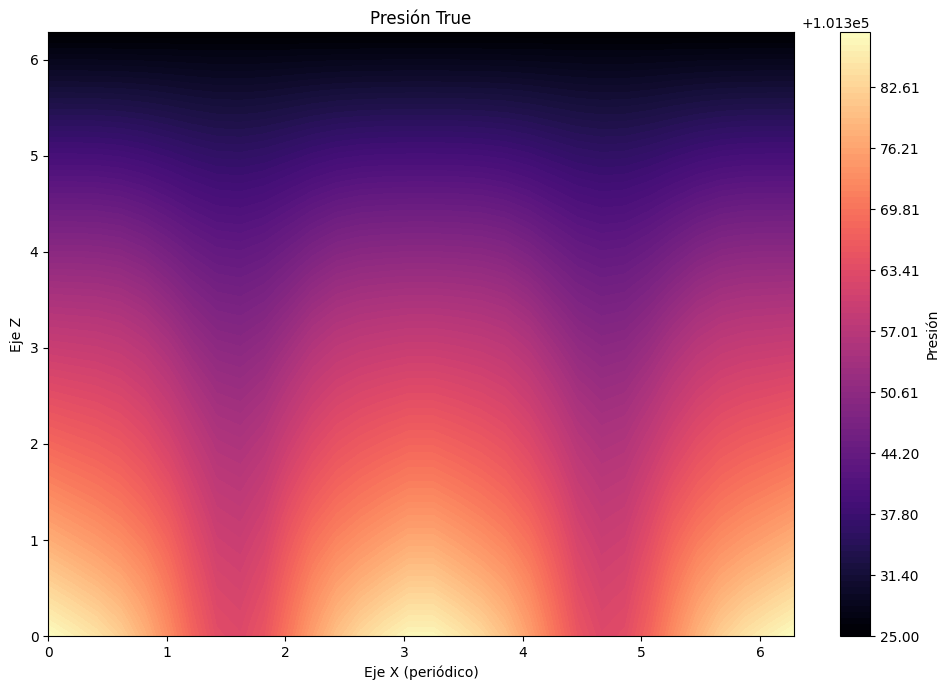

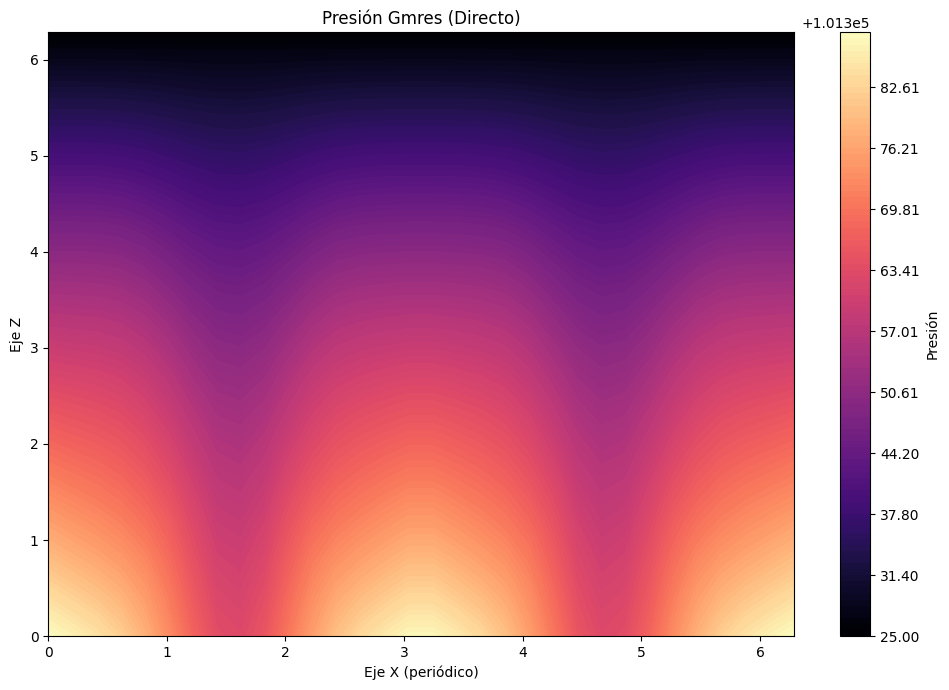

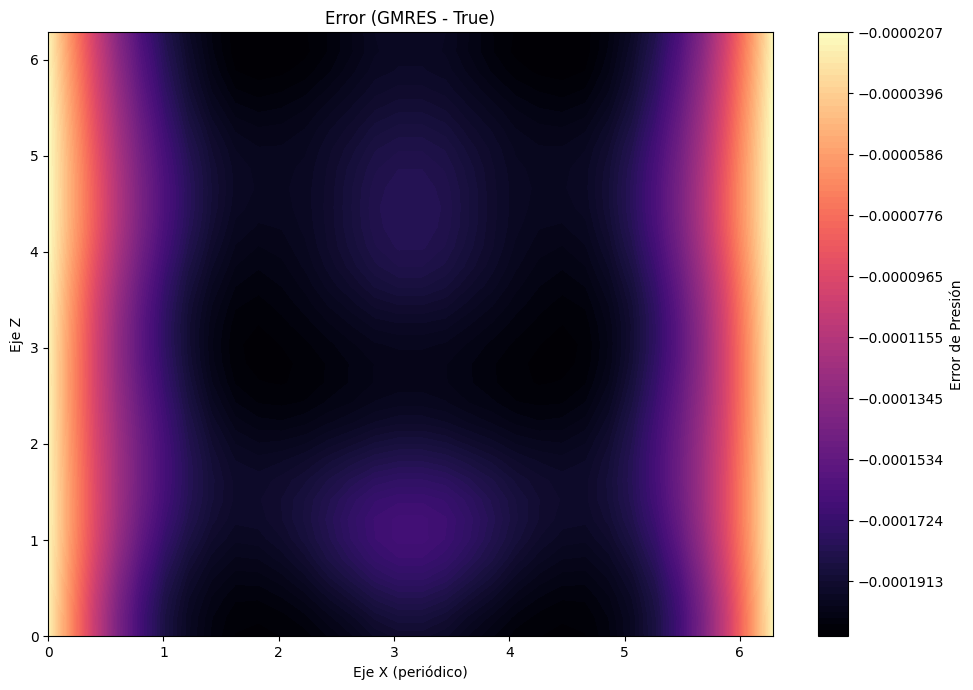

error respecto a p_true: 0.005449630837316236


In [12]:
def solve_direct_gmres(L, Gx_2d, Gz_2d, rho_vec, b, create_afun_func, Nx, Nz,
                       x0=None, 
                       restart=15, 
                       maxiter=200, 
                       atol=1e-10, 
                       rtol=1e-10, 
                       verbose=True):
    """
    Resuelve el sistema de Poisson de densidad variable A(p) = b usando
    el método GMRES directo.
    
    A(p) = ∇²p - (1/rho)·(∇rho · ∇p)
    """
    
    N_total = Nx * Nz
    
    if verbose:
        print("\n" + "="*70)
        print("MÉTODO 1: GMRES DIRECTO (NO SIMÉTRICO)")
        print("="*70)
        print("Creando 'afun' y LinearOperator para el sistema no simétrico...")

    afun, _, _ = create_afun_func(L, Gx_2d, Gz_2d, rho_vec)
    
    A_operator = LinearOperator(
        shape=(N_total, N_total),
        matvec=afun  
    )

    if x0 is None:
        p_init = np.zeros(N_total)
    else:
        p_init = x0

    residuals = []
    
    def callback(xk):
        r_vec = b - afun(xk)
        r_norm = np.linalg.norm(r_vec)
        residuals.append(r_norm)
        if verbose and len(residuals) % 10 == 0:
            print(f"    Iter {len(residuals):3d}: residual = {r_norm:.6e}")
    
    if verbose:
        print(f"Iniciando solver GMRES (maxiter={maxiter}, atol={atol}, rtol={rtol}, restart={restart})...")

    p_gmres, info = gmres(
        A=A_operator,
        b=b,
        x0=p_init,
        restart=restart,
        maxiter=maxiter,
        callback=callback,
        callback_type='x',
        atol=atol,         
        rtol=rtol
    )
    
    if verbose:
        print("\n" + "="*30)
        print("Reporte de Convergencia (GMRES Directo)")
        if info == 0:
            print(f":D GMRES CONVERGIÓ en {len(residuals)} iteraciones")
        else:
            print(f":c GMRES NO CONVERGIÓ (info={info})")
        
        if residuals:
            print(f"  Residual final: {residuals[-1]:.6e}")
        print("="*70)
        
        residual_vec = b - afun(p_gmres)
        residual_norm = np.linalg.norm(residual_vec)
        print(f"Verificación post-solver:")
        print(f"  ||b - A(p_sol)|| = {residual_norm:.6e}")
    
    return p_gmres, info, residuals

Nx = 32
Nz = 32
N_total = Nx * Nz

params = initialize_variables(Nx, Nz)
T = get_temperature_field(params)
rho = get_density_from_temperature(T, params)
p_true = get_pressure_from_density(rho, params)

L, Gx_2d, Gz_2d = build_2d_operators(Nx, Nz, params['dx'], params['dz'])
    
rho_vec = rho.flatten()
p_true_vec = p_true.flatten()

afun_base, _, _ = create_afun(L, Gx_2d, Gz_2d, rho_vec)
b = afun_base(p_true_vec)

# ===================================================================
p_gmres_vec, info, history = solve_direct_gmres(
    L, Gx_2d, Gz_2d, 
    rho_vec, 
    b, 
    create_afun,
    Nx, Nz,
    x0=np.zeros(N_total),
    restart=15,
    maxiter=200,
    atol=1e-10,  
    rtol=1e-10,
    verbose=True
)
# ===================================================================
print("\nAnálisis de la solución final:")
p_2d_gmres = p_gmres_vec.reshape((Nx, Nz))
plot_field(p_true, params, titulo="Presión True", label="Presión")
plot_field(p_2d_gmres, params, titulo="Presión Gmres (Directo)", label="Presión")
plot_field(p_2d_gmres - p_true, params, titulo="Error (GMRES - True)", label="Error de Presión")
print(f"error respecto a p_true: {np.linalg.norm(p_true_vec -p_gmres_vec)}")

# Propuesta 2: Iteración de punto fijo con GMRES

tenemos la IPF
$$
\begin{align*}
\nabla_h^2 \; p^{m+1} = \frac{\rho^n}{\Delta t} (\nabla_h \cdot u^* - \nabla \cdot u) + \frac{1}{\rho^n} \nabla_h \rho^N \cdot \nabla_h p^m \\

\nabla_h^2 \; p^{m+1} = b + \frac{1}{\rho^n} \nabla_h \rho^N \cdot \nabla_h p^m
\end{align*}
$$

- El término $b$ es conocido y fijo para todas las iteraciones.
- El término $\frac{1}{\rho^n} \nabla_h \rho^N \cdot \nabla_h p^m$ depende de $p^m$ que puede partir como un initial guess y se va actualizando en cada iteración.
- En cada iteración una vez calculado el término $\frac{1}{\rho^n} \nabla_h \rho^N \cdot \nabla_h p^m$ vamos a tener:
$$
\nabla_h^2 \; p^{m+1} = RHS
$$
- Ahora finalmente para encontrar $p^{m+1}$ podemos usarm GMRES con un `afun_laplacian(p)`




Pre-calculando términos constantes...
  |∇ρ| = 2.621186e+01

ITERACIÓN DE PUNTO FIJO
 Iter   |p^{m+1}-p^m|  GMRES iters    GMRES res
----------------------------------------------------------------------
    0    4.029443e+06            6 2.315777e-05
    1    9.799716e+05           10 1.852419e-05
    2    2.411374e+05           10 2.121586e-05
    3    5.910550e+04           11 2.078891e-05
    4    1.463823e+04           10 2.089282e-05
    5    3.571017e+03           10 2.076681e-05
    6    8.843844e+02            9 2.042352e-05
    7    2.150645e+02            9 2.096380e-05
    8    5.346285e+01            8 1.994444e-05
    9    1.297013e+01            7 2.040637e-05
   10    3.235433e+00            6 2.077150e-05
   11    7.815090e-01            6 2.085042e-05
   12    1.957313e-01            5 2.070678e-05
   13    4.692675e-02            4 2.045963e-05
   14    1.173581e-02            3 1.989577e-05
   15    2.725428e-03            2 2.007699e-05
   16    6.228937e-04      

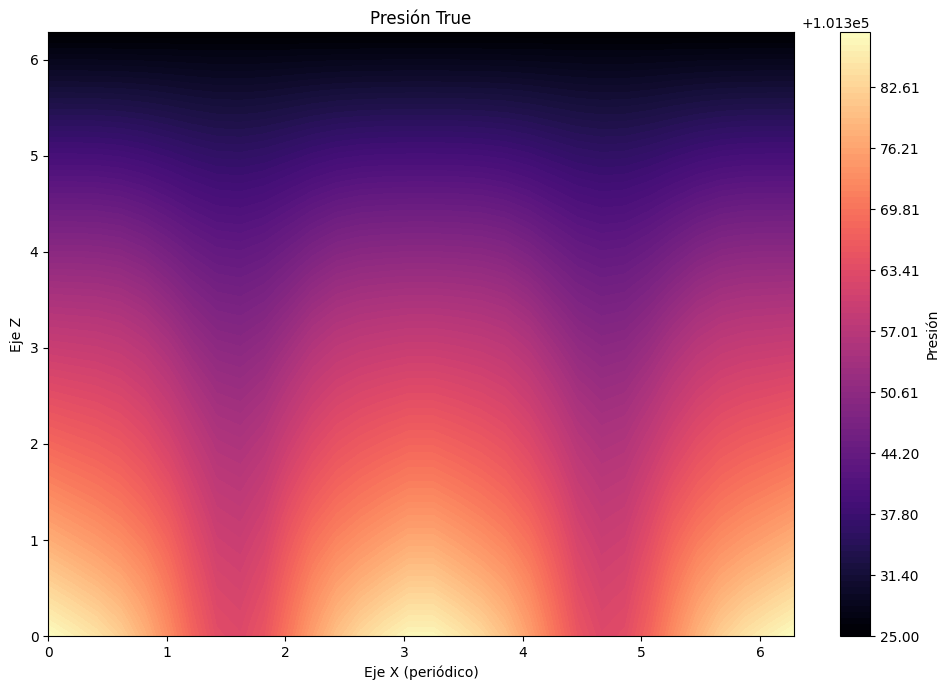

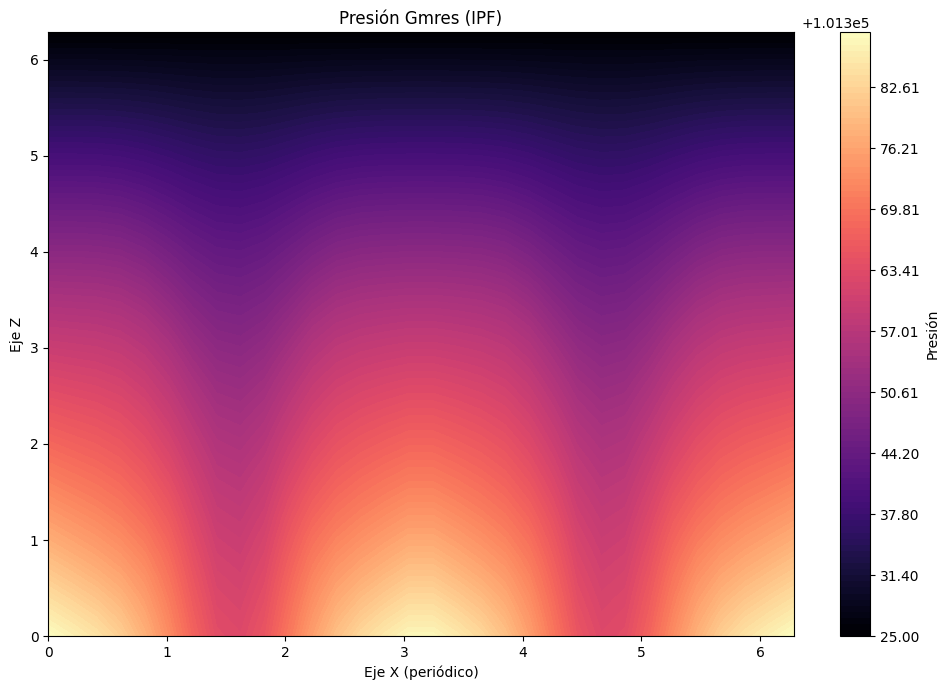

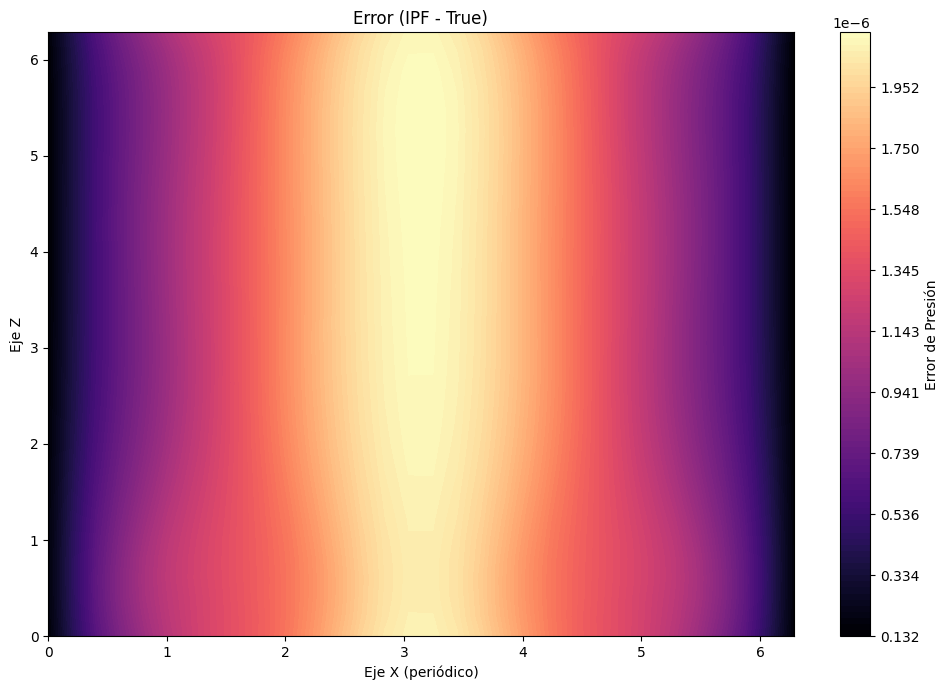

In [ ]:
def compute_correction_term(Gx_2d, Gz_2d, grad_rho_x, grad_rho_z, inv_rho, p_vec):
    grad_p_x = Gx_2d @ p_vec
    grad_p_z = Gz_2d @ p_vec
    dot_product = grad_rho_x * grad_p_x + grad_rho_z * grad_p_z
    correction = inv_rho * dot_product
    return correction

def solve_with_fixed_point(L, Gx_2d, Gz_2d, rho_vec, b, 
                           max_iter=50, tol=1e-6, verbose=True):
    N = len(b)
    if verbose:
        print("\nPre-calculando términos constantes...")
    
    grad_rho_x = Gx_2d @ rho_vec
    grad_rho_z = Gz_2d @ rho_vec
    inv_rho = 1.0 / np.maximum(rho_vec, 1e-10)
    
    if verbose:
        print(f"  |∇ρ| = {np.sqrt(np.linalg.norm(grad_rho_x)**2 + np.linalg.norm(grad_rho_z)**2):.6e}")
    
    def afun_laplacian(p):
        return L @ p
    
    A_lap = LinearOperator(shape=(N, N), matvec=afun_laplacian)
    p_m = np.zeros(N)
    
    history = {
        'fp_residuals': [],
        'gmres_iters': [],
        'gmres_residuals': []
    }
    
    if verbose:
        print("\n" + "="*70)
        print("ITERACIÓN DE PUNTO FIJO")
        print("="*70)
        print(f"{'Iter':>5} {'|p^{m+1}-p^m|':>15} {'GMRES iters':>12} {'GMRES res':>12}")
        print("-"*70)
    
    for m in range(max_iter):
        correction = compute_correction_term(Gx_2d, Gz_2d, grad_rho_x, 
                                            grad_rho_z, inv_rho, p_m)
        
        rhs_m = b + correction
        
        gmres_residuals = []
        def callback_gmres(xk):
            r = np.linalg.norm(rhs_m - afun_laplacian(xk))
            gmres_residuals.append(r)
        
        p_m_plus_1, info = gmres(
            A=A_lap,
            b=rhs_m,
            x0=p_m,
            restart=30,
            maxiter=100,
            callback=callback_gmres,
            callback_type='x',
            atol=1e-12,  
            rtol=1e-12,  
        )
        
        if info != 0 and verbose:
            print(f"\n GMRES info={info} en iteración {m}")
        
        fp_residual = np.linalg.norm(p_m_plus_1 - p_m)
        gmres_final_res = gmres_residuals[-1] if gmres_residuals else 0
        
        history['fp_residuals'].append(fp_residual)
        history['gmres_iters'].append(len(gmres_residuals))
        history['gmres_residuals'].append(gmres_final_res)
        
        if verbose:
            print(f"{m:5d} {fp_residual:15.6e} {len(gmres_residuals):12d} {gmres_final_res:12.6e}")
        
        if fp_residual < tol:
            if verbose:
                print("-"*70)
                print(f"✓ Convergió en {m+1} iteraciones")
                print("="*70)
            break
        
        p_m = p_m_plus_1
    else:
        if verbose:
            print("-"*70)
            print(f" NO convergió en {max_iter} iteraciones")
            print(f" Residual final: {fp_residual:.6e}")
            print("="*70)
    
    return p_m_plus_1, history


p_IPF, history_IPF = solve_with_fixed_point(L,Gx_2d,Gz_2d,rho_vec,b )

print(f"error respecto a p_true: {np.linalg.norm(p_true_vec -p_IPF)}")
p_2d_gmres_IPF = p_IPF.reshape((Nx, Nz))
plot_field(p_true, params, titulo="Presión True", label="Presión")
plot_field(p_2d_gmres_IPF, params, titulo="Presión Gmres (IPF)", label="Presión")
plot_field(p_2d_gmres_IPF - p_true, params, titulo="Error (IPF - True)", label="Error de Presión")

# Enfoque original FFT-FD


MÉTODO 3: IPF + FFT-FD (DIRICHLET-DIRICHLET)
  BC Z-min (Dirichlet): 0.0000 Pa
  BC Z-max (Dirichlet): 0.0000 Pa

 Iter   |p^{m+1}-p^m|
----------------------------------------------------------------------
    0    1.212606e+03
    1    5.889970e+02
    2    6.273636e+01
    3    6.855568e+01
    4    2.030380e+01
    5    6.427363e+00
    6    2.074012e+00
    7    6.164162e-01
    8    1.862155e-01
    9    5.686833e-02
   10    1.717159e-02
   11    5.193492e-03
   12    1.574601e-03
   13    4.765873e-04
   14    1.442669e-04
   15    4.369088e-05
   16    1.322765e-05
   17    4.004763e-06
   18    1.212602e-06
   19    3.671435e-07
   20    1.111599e-07
   21    3.365650e-08
   22    1.019052e-08
   23    3.085243e-09
   24    9.342798e-10
   25    2.824447e-10
   26    8.606811e-11
----------------------------------------------------------------------
✓ Convergió en 27 iteraciones

Solución IPF-FFTFD obtenida.
  Iteraciones: 27
  Residual final: 8.606811e-11
error respecto a p

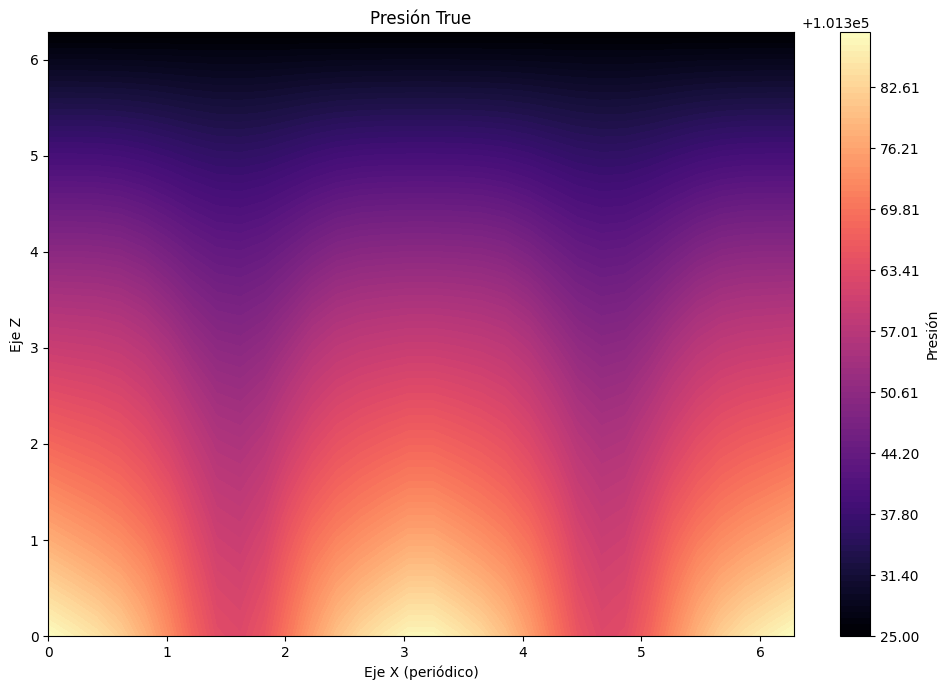

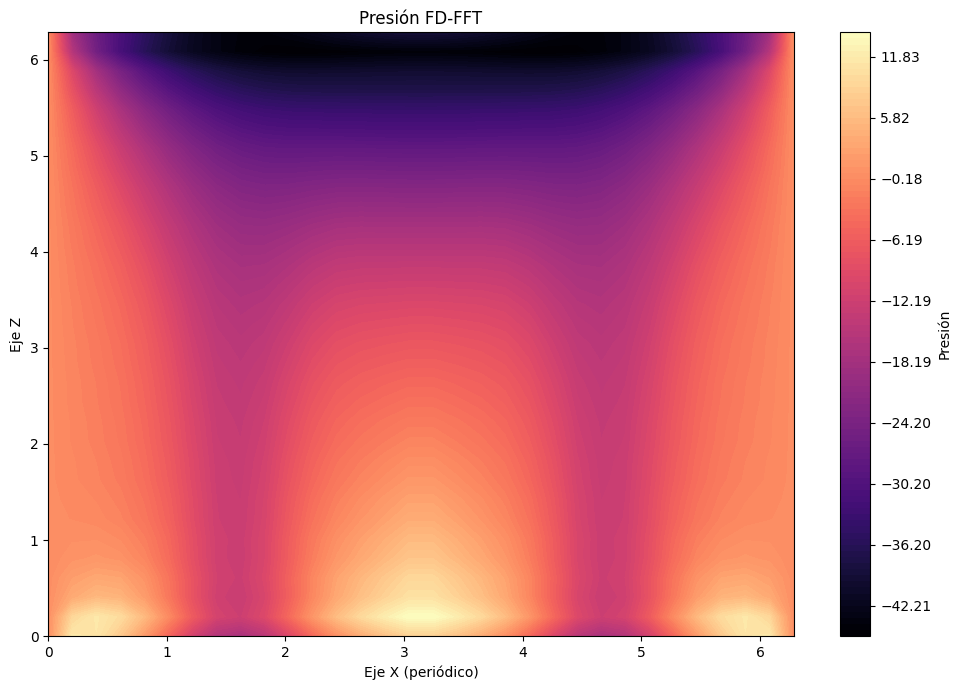

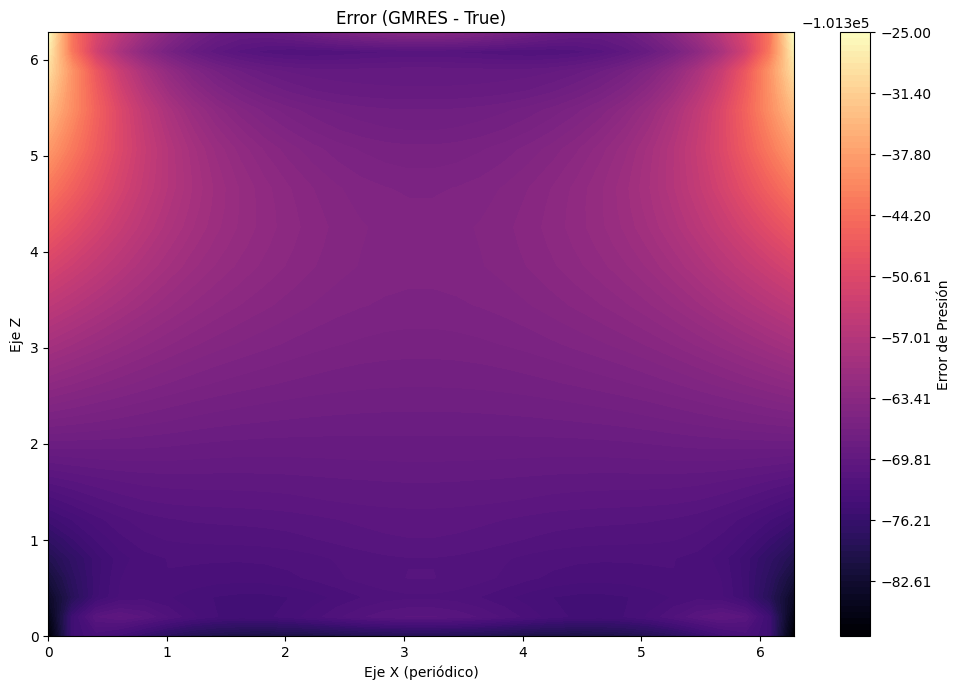

In [ ]:
def thomas_algorithm_complex(a: np.ndarray, b: np.ndarray, c: np.ndarray, f: np.ndarray) -> np.ndarray:
    """
    Resuelve un sistema lineal tridiagonal Ax = f usando el Algoritmo de Thomas.
    """
    N = b.shape[0]
    v = np.zeros(N, dtype=np.complex128)
    l = np.zeros(N - 1, dtype=np.complex128)
    y = np.zeros(f.shape, dtype=np.complex128)
    u = np.zeros(f.shape, dtype=np.complex128)
    
    v[0] = b[0]
    for k in range(1, N):
        l[k-1] = a[k-1] / v[k-1]
        v[k] = b[k] - l[k-1] * c[k-1]
        
    y[0] = f[0]
    for k in range(1, N):
        y[k] = f[k] - l[k-1] * y[k-1]
        
    u[-1] = y[-1] / v[-1]
    for k in range(-1, -N, -1):
        u[k-1] = (y[k-1] - c[k] * u[k]) / v[k-1]
        
    return u

def solve_laplacian_fftfd_Dirichlet(rhs_2d, params, p_bottom_val, p_top_val):
    """
    Resuelve ∇²p = rhs usando FFT en 'x' (periódico) y Algoritmo de Thomas
    en 'z' (Dirichlet en z=0 y z=Zmax).
    
    Esta versión es compatible con tu Método 1 (GMRES Directo).
    """
    Nx, Nz = params['Nx'], params['Nz']
    dx, dz = params['dx'], params['dz']
    
    
    Nz_sys = Nz - 2
    
    F_transposed = rhs_2d.T
    F = F_transposed[1:-1, :]
    F_k = np.fft.fft(F, axis=1)
    
    k_x_vec = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
    
    P_k_Zmin = np.fft.fft(np.ones(Nx) * p_bottom_val) # BC en z=0
    P_k_Zmax = np.fft.fft(np.ones(Nx) * p_top_val)   # BC en z=Zmax
    
    # Array para guardar la solución en espacio de Fourier
    P_k = np.zeros_like(F_k, dtype=np.complex128)

    # 3. RESOLVER SISTEMAS TRIDIAGONALES (Loop en k_x)
    for k_idx in range(Nx):
        k_x = k_x_vec[k_idx]
        
        # Ecuación 1D: (1/dz²)P_{j+1} + (-2/dz² - k_x²)P_j + (1/dz²)P_{j-1} = F_k
        
        # El "gamma" del artículo (escalado por dz²)
        gamma_k = -2.0 - (k_x * dz)**2
        
        # Crear diagonales para el sistema 1D de tamaño (Nz-2)
        a = np.ones(Nz_sys - 1) / dz**2  # Diagonal inferior
        b = np.ones(Nz_sys) * gamma_k / dz**2 # Diagonal principal
        c = np.ones(Nz_sys - 1) / dz**2  # Diagonal superior
        
        # RHS para este modo k_x
        rhs_k = F_k[:, k_idx]
        
        # --- Aplicar BCs Dirichlet ---
        
        # 1. Borde inferior (z=0, Dirichlet)
        # Se resta el término P_k_Zmin del RHS en la primera fila (j=1)
        rhs_k[0] -= P_k_Zmin[k_idx] / dz**2
            
        # 2. Borde superior (z=Zmax, Dirichlet)
        # Se resta el término P_k_Zmax del RHS en la última fila (j=Nz-2)
        rhs_k[-1] -= P_k_Zmax[k_idx] / dz**2
        
        # --- Resolver el sistema tridiagonal ---
        # Usamos la versión explícitamente compleja para Numba
        P_k[:, k_idx] = thomas_algorithm_complex(a, b, c, rhs_k)

    # 4. TRANSFORMADA INVERSA
    # Transformar de vuelta al espacio real (IFFT en axis=1)
    p_sol_transposed = np.real(np.fft.ifft(P_k, axis=1))
    
    p_bottom_row = (np.ones(Nx) * p_bottom_val).reshape(1, Nx)
    p_top_row = (np.ones(Nx) * p_top_val).reshape(1, Nx)
    
    p_full_transposed = np.vstack([p_bottom_row, p_sol_transposed, p_top_row])
    
    # Transponer de vuelta a (Nx, Nz)
    return p_full_transposed.T


def solve_with_fixed_point_FFTFD(Gx_2d, Gz_2d, rho_vec, b, params, p_true_2d,
                                 max_iter=50, tol=1e-6, verbose=True):
    """
    Resuelve usando IPF, llamando al solver FFT-FD (Dirichlet-Dirichlet).
    
    p_true_2d (Nx, Nz) se usa para extraer los valores de las BCs.
    """
    N = len(b)
    Nx, Nz = params['Nx'], params['Nz']
    
    # --- CAMBIO AQUÍ ---
    # Extraer valores de BCs de AMBOS bordes
    # Asumimos que son constantes, tomando la media de cada borde
    p_bottom_val = 0.0 # Borde en z=0
    p_top_val = 0.0   # Borde en z=Zmax
    
    if verbose:
        print("\n" + "="*70)
        print("MÉTODO 3: IPF + FFT-FD (DIRICHLET-DIRICHLET)")
        print("="*70)
        print(f"  BC Z-min (Dirichlet): {p_bottom_val:.4f} Pa")
        print(f"  BC Z-max (Dirichlet): {p_top_val:.4f} Pa")
    
    grad_rho_x = Gx_2d @ rho_vec
    grad_rho_z = Gz_2d @ rho_vec
    inv_rho = 1.0 / np.maximum(rho_vec, 1e-10)
    
    p_m_vec = np.zeros(N)
    history = {'fp_residuals': []}
    
    if verbose:
        print(f"\n{'Iter':>5} {'|p^{m+1}-p^m|':>15}")
        print("-"*70)
        
    for m in range(max_iter):
        correction = compute_correction_term(Gx_2d, Gz_2d, grad_rho_x, 
                                            grad_rho_z, inv_rho, p_m_vec)
        
        rhs_m_vec = b + correction
        rhs_m_2d = rhs_m_vec.reshape((Nx, Nz))
        
        p_m_plus_1_2d = solve_laplacian_fftfd_Dirichlet(
            rhs_m_2d, 
            params, 
            p_bottom_val, 
            p_top_val
        )
        
        p_m_plus_1_vec = p_m_plus_1_2d.flatten()
        
        fp_residual = np.linalg.norm(p_m_plus_1_vec - p_m_vec)
        history['fp_residuals'].append(fp_residual)
        
        if verbose:
            print(f"{m:5d} {fp_residual:15.6e}")
        
        if fp_residual < tol:
            if verbose:
                print("-"*70)
                print(f"✓ Convergió en {m+1} iteraciones")
                print("="*70)
            break
        
        p_m_vec = p_m_plus_1_vec
    else:
        if verbose:
            print("-"*70)
            print(f"✗ NO convergió en {max_iter} iteraciones")
            print("="*70)
            
    return p_m_plus_1_2d.flatten(), history # Retorna vector 1D



p_IPF_FFTFD, history_IPF_FFTFD = solve_with_fixed_point_FFTFD(
    Gx_2d, 
    Gz_2d, 
    rho_vec, 
    b,          # b = afun(p_true_vec)
    params, 
    p_true,     # p_true es (Nx, Nz)
    max_iter=300, 
    tol=1e-10
)

print(f"\nSolución IPF-FFTFD obtenida.")
print(f"  Iteraciones: {len(history_IPF_FFTFD['fp_residuals'])}")
print(f"  Residual final: {history_IPF_FFTFD['fp_residuals'][-1]:.6e}")
print(f"error respecto a p_true: {np.linalg.norm(p_true_vec - p_IPF_FFTFD.flatten())}")

p_2d_IPF_FFTFD = p_IPF_FFTFD.reshape((Nx, Nz))
plot_field(p_true, params, titulo="Presión True", label="Presión")
plot_field(p_2d_IPF_FFTFD, params, titulo="Presión FD-FFT", label="Presión")
plot_field(p_2d_IPF_FFTFD - p_true, params, titulo="Error (GMRES - True)", label="Error de Presión")

# Comparación Final

In [99]:
def run_scaling_study(grid_sizes, output_file="scaling_results.csv"):
    """
    Ejecuta el estudio de escalado para los 3 métodos y guarda los
    resultados (N, Método, Tiempo, Error) en un archivo CSV.
    """
    
    # Tolerancias estrictas para una comparación de precisión justa
    # (basado en tus experimentos anteriores)
    SOLVER_TOL = 1e-10 
    
    # --- Asumimos que estas funciones están definidas en otra parte ---
    # initialize_variables, get_temperature_field, get_density_from_temperature,
    # get_pressure_from_density, build_2d_operators, create_afun,
    # solve_direct_gmres, solve_with_fixed_point, solve_with_fixed_point_FFTFD
    # -----------------------------------------------------------------

    results = [] # Lista para guardar los diccionarios de resultados

    print(f"Iniciando estudio de escalado. Resultados se guardarán en: {output_file}")
    
    for size in grid_sizes:
        Nx = size
        Nz = size
        N_total = Nx * Nz
        print(f"\n--- Ejecutando Experimento: N = {Nx}x{Nz} = {N_total} ---")

        # ==========================================================
        # 1. SETUP (Se debe correr dentro del loop para cada 'size')
        # ==========================================================
        print(f"  [N={N_total}] 1. Generando malla y campos (true)...")
        params = initialize_variables(Nx, Nz)
        T = get_temperature_field(params)
        rho = get_density_from_temperature(T, params)
        p_true = get_pressure_from_density(rho, params)

        L, Gx_2d, Gz_2d = build_2d_operators(Nx, Nz, params['dx'], params['dz'])
            
        rho_vec = rho.flatten()
        p_true_vec = p_true.flatten()

        afun_base, _, _ = create_afun(L, Gx_2d, Gz_2d, rho_vec)
        b = afun_base(p_true_vec) # RHS
        
        # ==========================================================
        # 2. EXPERIMENTOS (Medición de tiempo y error)
        # ==========================================================
        
        # --- Método 1: GMRES Directo ---
        print(f"  [N={N_total}] 2. Corriendo Método 1: Direct-GMRES...")
        try:
            start_time = time.perf_counter()
            p_sol_1, info_1, _ = solve_direct_gmres(
                L, Gx_2d, Gz_2d, rho_vec, b, create_afun, Nx, Nz,
                x0=np.zeros(N_total),
                restart=30,  # Aumentamos 'restart' para grillas grandes
                maxiter=1000, # Aumentamos 'maxiter'
                atol=SOLVER_TOL,
                rtol=SOLVER_TOL,
                verbose=False # Silenciamos el output del solver
            )
            time_1 = time.perf_counter() - start_time
            error_1 = np.linalg.norm(p_true_vec - p_sol_1) if info_1 == 0 else np.nan
            
            results.append({
                "N": N_total, "Nx": Nx, "Method": "Direct-GMRES",
                "Time_s": time_1, "Error": error_1, "Success": info_1 == 0
            })
            print(f"      -> Tiempo: {time_1:.4f} s, Error: {error_1:.2e}")
        except Exception as e:
            print(f"      -> FALLÓ: {e}")

        # --- Método 2: IPF-GMRES ---
        print(f"  [N={N_total}] 3. Corriendo Método 2: IPF-GMRES...")
        try:
            start_time = time.perf_counter()
            # Asumimos que 'solve_with_fixed_point' usa internamente
            # las tolerancias estrictas (atol/rtol=1e-12) que descubriste.
            p_sol_2, hist_2 = solve_with_fixed_point(
                L, Gx_2d, Gz_2d, rho_vec, b,
                max_iter=100, tol=1e-8, verbose=False
            )
            time_2 = time.perf_counter() - start_time
            error_2 = np.linalg.norm(p_true_vec - p_sol_2)
            
            results.append({
                "N": N_total, "Nx": Nx, "Method": "IPF-GMRES",
                "Time_s": time_2, "Error": error_2, "Success": True
            })
            print(f"      -> Tiempo: {time_2:.4f} s, Error: {error_2:.2e}")
        except Exception as e:
            print(f"      -> FALLÓ: {e}")
            
        # --- Método 3: IPF-FFTFD ---
        print(f"  [N={N_total}] 4. Corriendo Método 3: IPF-FFTFD (Paper)...")
        try:
            start_time = time.perf_counter()
            # Usamos la versión Dirichlet-Dirichlet que corrige las BCs
            p_sol_3, hist_3 = solve_with_fixed_point_FFTFD(
                Gx_2d, Gz_2d, rho_vec, b, params, p_true,
                max_iter=100, tol=1e-8, verbose=False
            )
            time_3 = time.perf_counter() - start_time
            error_3 = np.linalg.norm(p_true_vec - p_sol_3)
            
            results.append({
                "N": N_total, "Nx": Nx, "Method": "IPF-FFTFD",
                "Time_s": time_3, "Error": error_3, "Success": True
            })
            print(f"      -> Tiempo: {time_3:.4f} s, Error: {error_3:.2e}")
        except Exception as e:
            print(f"      -> FALLÓ: {e}")

    # ==========================================================
    # 3. GUARDAR RESULTADOS
    # ==========================================================
    df = pd.DataFrame(results)
    
    # Manejar corridas múltiples: si el archivo existe, concatena
    if os.path.exists(output_file):
        print(f"Archivo '{output_file}' encontrado. Añadiendo nuevos resultados.")
        df_antiguo = pd.read_csv(output_file)
        df = pd.concat([df_antiguo, df]).drop_duplicates(subset=['N', 'Method'], keep='last')
    
    df.to_csv(output_file, index=False)
    print(f"\n¡Estudio completado! Resultados guardados en '{output_file}'.")
    
    return df

def plot_scaling_results_separate(results_file="scaling_results.csv", title_fontsize=18):
    """
    Lee el archivo CSV de resultados y genera dos gráficos de escalado
    separados (Tiempo y Error), sin etiquetas en los ejes.
    """
    try:
        df = pd.read_csv(results_file)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{results_file}'.")
        print("Por favor, ejecuta 'run_scaling_study' primero.")
        return
        
    df = df.sort_values(by="N")
    methods = df["Method"].unique()
    
    # --- Gráfico 1: Escalado de Tiempo (Log-Log) ---
    plt.figure(figsize=(9, 7)) # Crear la primera figura
    ax1 = plt.gca() # Obtener el eje actual
    
    for method in methods:
        method_data = df[df["Method"] == method]
        ax1.plot(method_data["N"], method_data["Time_s"], 'o-', label=method, markersize=8)
    
    ax1.set_title("", fontsize=title_fontsize) # Título personalizado
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.legend(fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    # Quitar etiquetas de los ejes
    ax1.set_xlabel("Total Unknowns (N)", fontsize=14)
    ax1.set_ylabel("Time (s)", fontsize=14)
    
    plt.tight_layout()
    plt.show() # Mostrar la primera figura

    # --- Gráfico 2: Convergencia de Error (Log-Log) ---
    plt.figure(figsize=(9, 7)) # Crear la segunda figura
    ax2 = plt.gca() # Obtener el eje actual
    
    for method in methods:
        method_data = df[df["Method"] == method]
        ax2.plot(method_data["N"], method_data["Error"], 's-', label=method, markersize=8)
    
    ax2.set_title("Unknows VS L2 Error", fontsize=title_fontsize) # Título descriptivo
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.legend(fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    # Quitar etiquetas de los ejes
    ax2.set_xlabel("")
    ax2.set_ylabel("")

    plt.tight_layout()
    plt.show() # Mostrar la segunda figura

In [103]:
def print_summary_from_file(results_file="scaling_results_heavy.csv"):
    """
    Lee el archivo CSV de resultados (sin correr experimentos)
    y muestra un resumen en consola de (Método, Nx, Tiempo).
    """
    print(f"\n--- Resumen de Resultados desde: {results_file} ---")
    
    # 1. Verificar si el archivo existe
    if not os.path.exists(results_file):
        print(f"Error: No se encontró el archivo '{results_file}'.")
        print("Asegúrate de que el nombre y la ruta sean correctos.")
        return

    try:
        # 2. Leer el archivo CSV
        df = pd.read_csv(results_file)
        
        # 3. Seleccionar las columnas que quieres
        df_resumen = df[['Method', 'Nx', 'Time_s']]
        
        # 4. Ordenar los valores para que sean fáciles de leer
        df_sorted = df_resumen.sort_values(by=['Nx', 'Method'])
        
        # 5. Imprimir en consola sin el índice
        print(df_sorted.to_string(index=False))

    except FileNotFoundError:
        # Esto es redundante si ya usamos os.path.exists, pero es buena práctica
        print(f"Error: No se encontró el archivo '{results_file}'.")
    except pd.errors.EmptyDataError:
        print(f"Error: El archivo '{results_file}' está vacío.")
    except KeyError:
        print("Error: El archivo CSV no contiene las columnas requeridas (Method, Nx, Time_s).")
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}")

# --- CÓMO USARLA ---
#
# Simplemente llama a la función así:
#
print_summary_from_file("scaling_results_heavy.csv")
#


--- Resumen de Resultados desde: scaling_results_heavy.csv ---
      Method  Nx     Time_s
Direct-GMRES   8   0.001841
   IPF-FFTFD   8   0.001651
   IPF-GMRES   8   0.009773
Direct-GMRES  16   0.006164
   IPF-FFTFD  16   0.004875
   IPF-GMRES  16   0.031544
Direct-GMRES  32   0.072399
   IPF-FFTFD  32   0.018798
   IPF-GMRES  32   0.144649
Direct-GMRES  64   0.179593
   IPF-FFTFD  64   0.073812
   IPF-GMRES  64   1.842275
Direct-GMRES 128   1.261142
   IPF-FFTFD 128   0.302083
   IPF-GMRES 128  13.785134
Direct-GMRES 256  15.735231
   IPF-FFTFD 256   1.180406
   IPF-GMRES 256  57.660689
Direct-GMRES 512 213.423565
   IPF-FFTFD 512   6.525478
   IPF-GMRES 512 331.844251


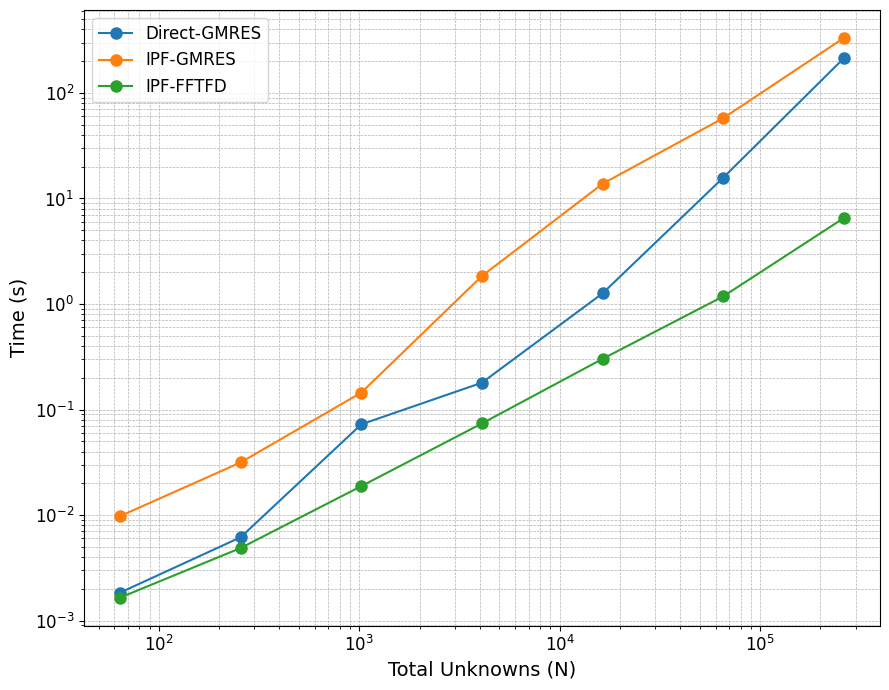

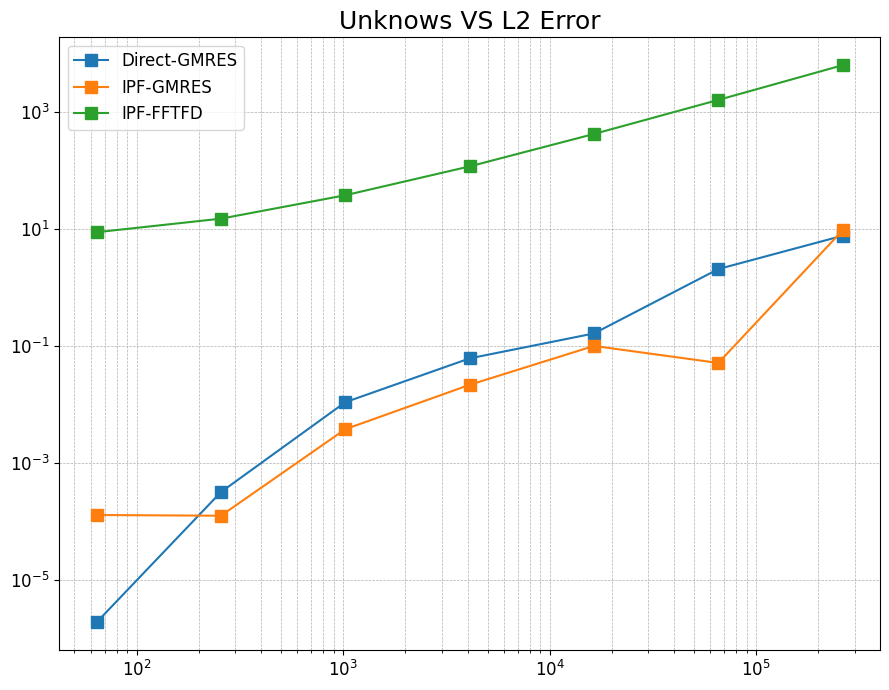

In [100]:
# grid_sizes_to_test = [16,32] 
# run_scaling_study(grid_sizes_to_test)

plot_scaling_results_separate("scaling_results_heavy.csv")